# FIT 5202 - Data Processing for Big Data

#### Name: Ng Jade Kuan

#### Student ID: 25510487

#### Tutorial Day: Wednesday, 8 am - 10 am

##### Tutor : Peter Liu

##### Python Version: 3.6.8

#### Spark Version: 2.4.3

## Step 1: Import Pyspark and initialize Spark
This step, I am importing sparkcontext from pyspark which is the main entry point for Spark Core functionality. The SparkSession object provides methods used to create DataFrames from various input sources. 



In [55]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
my_spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("crime_statistics") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/crimestats_db.crime_stats") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/crimestats_db.crime_stats") \
    .getOrCreate()

### Importing libraries needed

In [56]:
# importing libraries 
from datetime import datetime
from pyspark.sql.functions import col,udf
from pyspark.sql.types import DateType
from pyspark.sql import functions as f
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql.functions import date_format



## Step 2 Create Dataframe

For this section, I am creating a dataframe and providing the data source as the csv file. The total of records in the dataframe is also shown.

In [57]:
zips_df = my_spark.read.csv('Crime_Statistics_SA_2010_present.csv', header = True)
# step below is to get the total records in file. Minus one is used to the minus header from the count.
print('Number of records in dataframe:',zips_df.count() -1)

Number of records in dataframe: 727407


## Step 3 Write to Database

Since, I am using MongoDB as my data source, hence as the data loading step I am required to read the CSV file using spark session and insert all the records into MongoDB. An overwrite mode is used when inserting the data to MongoDB.

In [58]:
# inserting records to mongodb  with overwrite mode
zips_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()
zips_df.show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

## Step 4 Read from Database

In this subsection, I am creating a Spark DataFrame to hold data from the MongoDB collection specified in the spark.mongodb.input.uri option which my SparkSession option is using. I've assigned the collection to a DataFrame with spark.read()

In [59]:
# Write to MongoDB

zips_df = my_spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [60]:
# display schema
zips_df.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 5 Calculating stats of numeric and string columns

In this subsection, I'm calculating the statistics of "Offence Count" and "Reported Date". I've found the count, mean, standard deviation, minimum and maximum for these two attributes using the describe function. 

In [61]:
# using describe function to show statistics
zips_df.describe('Offence Count','Reported Date').show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378078|         null|
|    min|                 1|    1/01/2011|
|    max|                 9|    9/12/2018|
+-------+------------------+-------------+



In [62]:
# showing first two lines of dataframe
zips_df.show(2)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|               5000|    1/07/2010|         ADELAIDE|[5d71e2ae56389f08...|
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5000|    1/07/2010|         ADELAIDE|[5d71e2ae56389f08...|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+--

#### Based on the table above, the minimum and maximum date is not reported correctly. As we can see when we show the first two lines in the dataframe, the minimum date is 1/07/2010 compared to the minimum date 1/01/2011 displayed in the describe function. This is because a string does not have a minimum or maximum value. 

## Step 6 Change data type of a column

For this subsection, I am changing the date column which is in string format to date format using the user defined functions

In [63]:
# this function converts string cell to date
func = udf(lambda x: datetime.strptime (x,'%d/%m/%Y'),DateType())
# dropping nulls and applying function to reported date column
df = zips_df.na.drop().withColumn('Reported Date',func(col('Reported Date')))
# showing top 5 values
df.show(5)

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|               5000|   2010-07-01|         ADELAIDE|[5d71e2ae56389f08...|
|            2|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|               5000|   2010-07-01|         ADELAIDE|[5d71e2ae56389f08...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|               5000|   2010-07-01|  

In [64]:
# printing schema to check if data type for reported date is changed
df.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



## Step 7 Preliminary data analysis

For this subsection, I am answering the following analytical queries:
i. How many level 2 offences there are and I am displaying the list of level 2 offences
ii. The number of offences against the person
iii. Total serious criminal trespasses with more than 1 offence count
iv. Percentage of crimes are offences against the property

### i. This displays the list of level 2 offences and the count of the total level 2 offences

In [65]:
# im selecting the offence level 2 description and dropping null and duplicate values. truncate = false is used in order
# to display the description as a whole
df.select('Offence Level 2 Description').na.drop().dropDuplicates().show(truncate = False)

# this is to obtain the count of the offence description
print('Total level 2 offences are:', df.select('Offence Level 2 Description').distinct().na.drop().count())


+------------------------------------+
|Offence Level 2 Description         |
+------------------------------------+
|ROBBERY AND RELATED OFFENCES        |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |
|SEXUAL ASSAULT AND RELATED OFFENCES |
|HOMICIDE AND RELATED OFFENCES       |
|ACTS INTENDED TO CAUSE INJURY       |
|SERIOUS CRIMINAL TRESPASS           |
|OTHER OFFENCES AGAINST THE PERSON   |
|FRAUD DECEPTION AND RELATED OFFENCES|
|THEFT AND RELATED OFFENCES          |
+------------------------------------+

Total level 2 offences are: 9


### ii. This displays the number of offences against the person

In [66]:
# filtering offences against the person in the offence level 1 description column and then counting it once filtered
print("Total Number of Offences Against the Person:",df.filter(df["Offence Level 1 Description"] == "OFFENCES AGAINST THE PERSON").count())

Total Number of Offences Against the Person: 155909


### iii.This displays how many serious criminal trespasses with more than 1 offence count

In [67]:
# filtering serious criminal trespass from offence level 2 description column and filtering it with offence count more than 1 then getting the count of the filtered values
print("Total Number of Serious Criminal Trespass With More Than 1 Offence Count:", df.filter((df["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS") & (df["Offence Count"] >1)).count())

Total Number of Serious Criminal Trespass With More Than 1 Offence Count: 8574


### iv. This shows the percentage of crimes which are offences against the property

In [68]:
# getting the count of filtered offences against property in the offence level 1 description column
property_offences = df.filter(df["Offence Level 1 Description"] == "OFFENCES AGAINST PROPERTY").count()
# getting the count of offence level 1 description column
offence_count = df.select("Offence Level 1 Description").count()
# getting percentage by dividing offences against porperty against total offence level 1 description 
# and multiplying by 100
print("Percentage of crimes which are offences against property",(property_offences/offence_count)*100,"%")

Percentage of crimes which are offences against property 78.55213977860043 %


## Step 8 Exploratory data analysis

In this step, I am analyzing the following analytical queries and visualising it using the standard python library matplotlib. The analytical queries are:

i. Finding the number of crimes per year

ii. Finding the number of crimes per month

iii. Finding out the top 20 suburbs and displaying the poscode where most crimes take place

iv. Finding the number of serious criminal trespass by day and month

### i. Finding number of crimes per year 

In [71]:
# splitting values in reported date rows based on - 
column_split = f.split(df['Reported Date'],'-')

# creating new column of year and month 
df = df.withColumn('Year',column_split.getItem(0))
df = df.withColumn('Month',column_split.getItem(1))

# grouping by year and sorting based on year in ascending order along with count
count_year = df.groupBy('Year').count().sort('Year').collect()
# grouping by month and sorting based on month in ascending order along with count
count_month = df.groupBy('Month').count().sort('Month').collect()


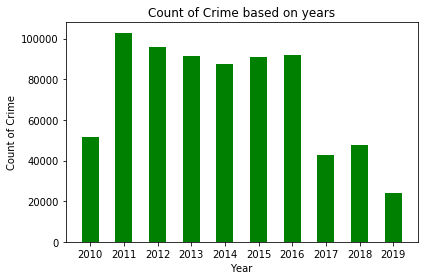

In [72]:
#prepare data
y_axis = [row['count'] for row in count_year]

# plot
bar_width = 0.5
objects= ('2010', '2011','2012','2013','2014','2015','2016','2017','2018','2019')
y_pos = np.arange(len(objects))


# plotting bar with y_pos which is the count of crimes of year as y axis with years as x axis 
plt.bar(y_pos, y_axis, bar_width, align='center', color='green')
plt.xticks(y_pos, objects) # x labels which include individual year
plt.xlabel('Year')
plt.ylabel('Count of Crime')
plt.title('Count of Crime based on years')
plt.tight_layout()
plt.show()

#### Based on the graph above we can see the maximum total crime is in the year 2011 where as the lowest count of crime would be in the year 2019. There was a significant increase in the count of crime from the year 2010 to 2011 followed by a gradual decline to 2014. In the year 2015 to 2016, total crime increased gradually, then had a steep decline in 2017. Between 2017 to 2018 there was a slight increase in crime followed by a major decline in crime in 2019.


### ii) Finding number of crimes per month

In [73]:
count_month

[Row(Month='01', count=65678),
 Row(Month='02', count=59912),
 Row(Month='03', count=63755),
 Row(Month='04', count=51388),
 Row(Month='05', count=55028),
 Row(Month='06', count=51901),
 Row(Month='07', count=60635),
 Row(Month='08', count=62509),
 Row(Month='09', count=62192),
 Row(Month='10', count=65568),
 Row(Month='11', count=64233),
 Row(Month='12', count=64122)]

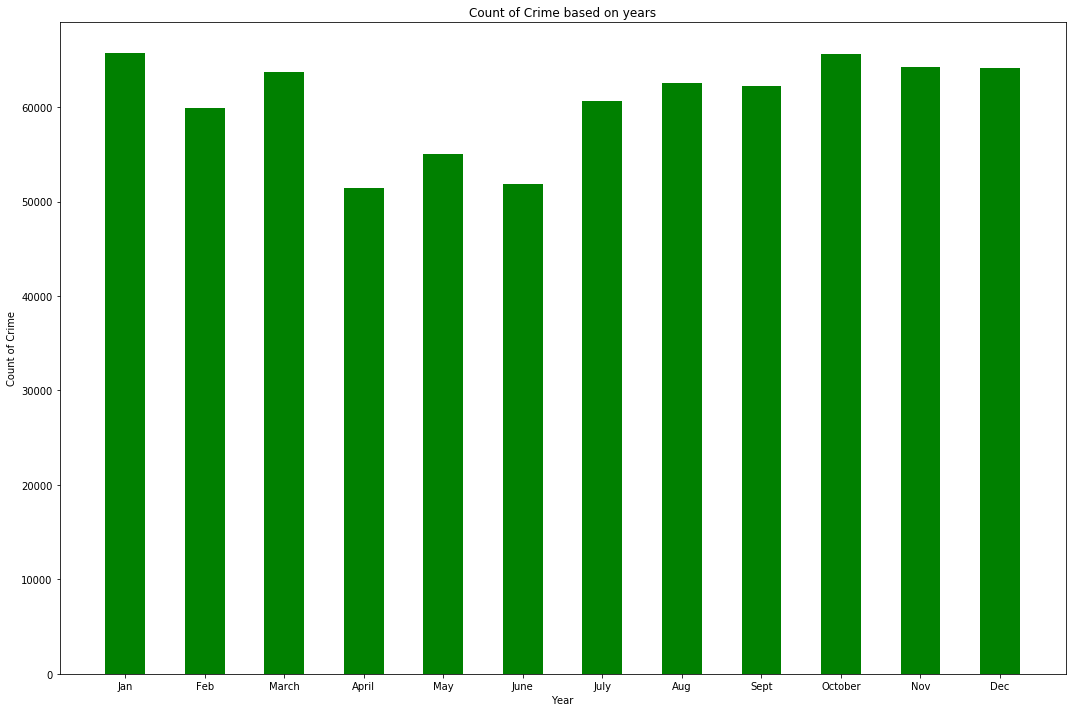

In [74]:
#prepare data
y_axis = [row['count'] for row in count_month]

plt.subplots(figsize = (15,10)) # figure size
bar_width = 0.5
objects= ('Jan','Feb','March','April','May','June','July','Aug','Sept','October','Nov','Dec')
y_pos = np.arange(len(objects))

# plotting bar with y_pos which is the count of crimes of month as y axis with months as x axis 
plt.bar(y_pos, y_axis, bar_width, align='center', color='green')

plt.xticks(y_pos, objects)
plt.xlabel('Year')
plt.ylabel('Count of Crime')
plt.title('Count of Crime based on years')

plt.tight_layout()
plt.show()

#### As we can see in the plot above, the crime rate for January is the highest, while the lowest crime rate is in April. Crime rate is relatively lower in the month of April, May and June.

### iii)  Finding out the top 20 suburbs and displaying the poscode where most crimes take place

In [75]:
#merging suburb with postcode 
df = df.withColumn('joined_column', 
                    f.concat(f.col('Suburb - Incident'),f.lit('-'), f.col('Postcode - Incident')))

In [76]:
# getting count for joined column and arranging them based on the top 20 count  
suburb_count = df.groupBy('joined_column').count().sort('count',ascending=False).take(20)
suburb_count

[Row(joined_column='ADELAIDE-5000', count=21684),
 Row(joined_column='MOUNT GAMBIER-5290', count=10000),
 Row(joined_column='PORT AUGUSTA-5700', count=9619),
 Row(joined_column='MORPHETT VALE-5162', count=9548),
 Row(joined_column='MURRAY BRIDGE-5253', count=9423),
 Row(joined_column='NOT DISCLOSED-NOT DISCLOSED', count=8939),
 Row(joined_column='SALISBURY-5108', count=8332),
 Row(joined_column='PORT LINCOLN-5606', count=7848),
 Row(joined_column='ELIZABETH-5112', count=7686),
 Row(joined_column='PARAFIELD GARDENS-5107', count=6640),
 Row(joined_column='DAVOREN PARK-5113', count=6519),
 Row(joined_column='PARALOWIE-5108', count=6084),
 Row(joined_column='PROSPECT-5082', count=5927),
 Row(joined_column='PORT PIRIE-5540', count=5772),
 Row(joined_column='OAKLANDS PARK-5046', count=5668),
 Row(joined_column='MODBURY-5092', count=5537),
 Row(joined_column='SALISBURY NORTH-5108', count=5492),
 Row(joined_column='SMITHFIELD-5114', count=5412),
 Row(joined_column='WHYALLA STUART-5608', count=

In [77]:
# getting a list of count for suburb count
y_axis1 = [row['count'] for row in suburb_count]
# getting a list of joined column which consist of suburb and postcode merged
x_axis1 = [row['joined_column'] for row in suburb_count]

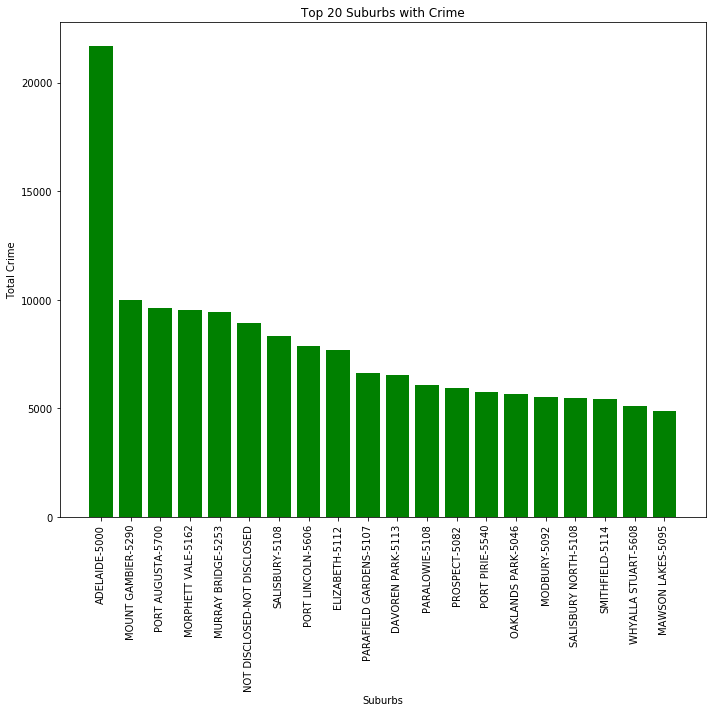

In [78]:
plt.subplots(figsize = (10,10)) # figure size

# plotting bar with y_axis1 which is the count of crimes by suburb with postcode as y axis with suburbs and postcode
#as x axis 
plt.bar(x_axis1, y_axis1,align='center', color='green')
plt.xticks(x_axis1,rotation = 90) # xlabels
plt.xlabel('Suburbs')
plt.ylabel('Total Crime')
plt.title('Top 20 Suburbs with Crime')
plt.tight_layout()
plt.show()

#### Based on the bar graph above, we can see that the highest total crime is in Adelaide - 5000 where as the lowest among the top 20 suburbs in terms of crime rate is Mawson Lakes - 5095. We can see that the total crime in Adelaide -5000 is significantly higher compared to the other suburbs.

### iv) Finding the number of serious criminal trespass by day and month

In [79]:
# formatting date to numerical values based on date using date_format function. the numerical date values is then 
# placed in new days column
days_column = df.select('Reported Date',date_format('Reported Date','u').alias('Days'))

In [80]:
days_column.show(5)

+-------------+----+
|Reported Date|Days|
+-------------+----+
|   2010-07-01|   4|
|   2010-07-01|   4|
|   2010-07-01|   4|
|   2010-07-01|   4|
|   2010-07-01|   4|
+-------------+----+
only showing top 5 rows



In [81]:
# split reported date column in days_column dataframe based on -
column_split = f.split(days_column['Reported Date'],'-')
# creating a new column in days_column dataframe based on month obtained from split. 
days1 = days_column.withColumn('Month',column_split.getItem(1))
days1.show()

+-------------+----+-----+
|Reported Date|Days|Month|
+-------------+----+-----+
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
|   2010-07-01|   4|   07|
+-------------+----+-----+
only showing top 20 rows



In [82]:
count_month

[Row(Month='01', count=65678),
 Row(Month='02', count=59912),
 Row(Month='03', count=63755),
 Row(Month='04', count=51388),
 Row(Month='05', count=55028),
 Row(Month='06', count=51901),
 Row(Month='07', count=60635),
 Row(Month='08', count=62509),
 Row(Month='09', count=62192),
 Row(Month='10', count=65568),
 Row(Month='11', count=64233),
 Row(Month='12', count=64122)]

In [89]:
# getting a list based on grouped days and month which are in order
p = days1.groupBy(['Days','Month']).count().orderBy(['Days','Month']).collect()
p

[Row(Days='1', Month='01', count=10313),
 Row(Days='1', Month='02', count=10173),
 Row(Days='1', Month='03', count=9934),
 Row(Days='1', Month='04', count=8096),
 Row(Days='1', Month='05', count=9314),
 Row(Days='1', Month='06', count=8214),
 Row(Days='1', Month='07', count=9939),
 Row(Days='1', Month='08', count=10849),
 Row(Days='1', Month='09', count=10337),
 Row(Days='1', Month='10', count=10717),
 Row(Days='1', Month='11', count=10857),
 Row(Days='1', Month='12', count=10713),
 Row(Days='2', Month='01', count=10144),
 Row(Days='2', Month='02', count=8685),
 Row(Days='2', Month='03', count=9795),
 Row(Days='2', Month='04', count=7888),
 Row(Days='2', Month='05', count=8335),
 Row(Days='2', Month='06', count=7625),
 Row(Days='2', Month='07', count=8940),
 Row(Days='2', Month='08', count=9022),
 Row(Days='2', Month='09', count=8993),
 Row(Days='2', Month='10', count=9964),
 Row(Days='2', Month='11', count=9483),
 Row(Days='2', Month='12', count=9203),
 Row(Days='3', Month='01', count

In [90]:
# for this step I am iterating through every row in p and getting the count. this will form a list of values of the count
# stored in a variable height. Then I am interating through the the list stored in variable height and obtaining every 12
#values and storing them into a list. so I'll have 7 individual lists which stores 12 values each which would be 
# months
heights = []
height = [row['count'] for row in p]
for i in range(0,len(height),12):
    heights.append(height[i:i+12])

heights   

[[10313,
  10173,
  9934,
  8096,
  9314,
  8214,
  9939,
  10849,
  10337,
  10717,
  10857,
  10713],
 [10144, 8685, 9795, 7888, 8335, 7625, 8940, 9022, 8993, 9964, 9483, 9203],
 [9497, 8628, 9045, 7572, 7683, 7705, 8666, 8982, 8909, 9747, 9126, 9229],
 [9373, 8701, 9314, 7375, 7899, 7790, 8527, 8939, 9198, 9266, 9143, 9384],
 [9565, 8532, 9145, 7199, 8009, 7516, 8856, 9159, 8906, 9176, 9420, 9149],
 [8246, 7607, 8222, 6659, 6726, 6523, 7764, 7810, 7782, 8444, 8091, 8389],
 [8540, 7586, 8300, 6599, 7062, 6528, 7943, 7748, 8067, 8254, 8113, 8055]]

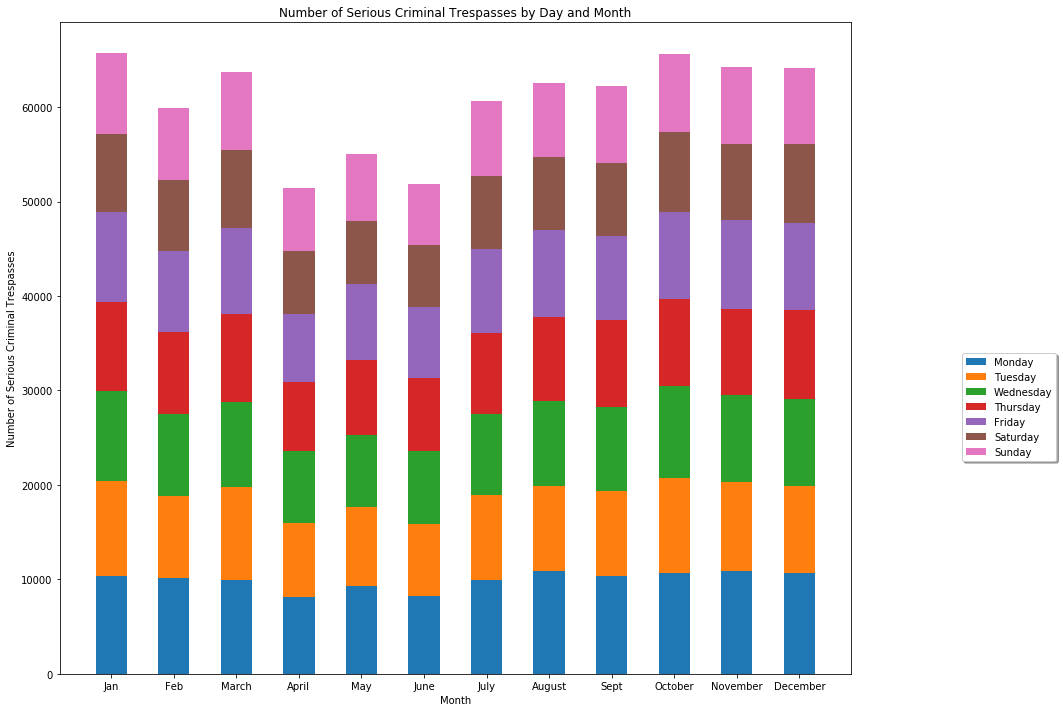

In [91]:
# plotting stackbar
plt.subplots(figsize = (15,10)) # fig size
bar_width = 0.5


p1 = plt.bar(y_pos,heights[0],bar_width,bottom = 0) 
p2 = plt.bar(y_pos,heights[1],bar_width,bottom = np.array(heights[0]))
p3 = plt.bar(y_pos,heights[2],bar_width,bottom = np.array(heights[0]) + np.array(heights[1]))
p4 = plt.bar(y_pos,heights[3],bar_width,bottom = np.array(heights[0]) + np.array(heights[1]) + np.array(heights[2]))
p5 = plt.bar(y_pos,heights[4],bar_width,bottom = np.array(heights[0]) + np.array(heights[1]) + np.array(heights[2]) + np.array(heights[3]))       
p6 = plt.bar(y_pos,heights[5],bar_width,bottom = np.array(heights[0]) + np.array(heights[1]) + np.array(heights[2]) + np.array(heights[3]) + np.array(heights[4]))
p7 = plt.bar(y_pos,heights[6],bar_width,bottom = np.array(heights[0]) + np.array(heights[1]) + np.array(heights[2]) + np.array(heights[3])+ np.array(heights[4]) + np.array(heights[5]))

objects = ('Jan','Feb','March','April','May','June','July','August','Sept','October','November','December')
y_pos = np.arange(len(objects))
days = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')

#labelling
plt.xlabel('Month')
plt.ylabel('Number of Serious Criminal Trespasses')
plt.title('Number of Serious Criminal Trespasses by Day and Month')
plt.xticks(y_pos,objects)

#plotting legend and showing graph
plt.legend(days , loc = 'upper center', bbox_to_anchor = (1.2,0.5),shadow = True) 
plt.tight_layout()
plt.show()


#### As, we can see in the stacked graph above, January and October have the highest number of serious trespasses where as April and June tend to have the lowest number of serious trespasses. In terms of days, Monday seems to have the highest number of trespasses in all the months.


References:

https://stackoverflow.com/questions/38080748/convert-pyspark-string-to-date-format
https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib